In [ ]:
import pandas as pd
import os
from functools import reduce
import numpy as np
from scipy.stats import pearsonr
from sklearn.decomposition import FactorAnalysis
import matplotlib.pyplot as plt
from data_functions import (
    scaling, 
    permutation_null_distro, 
    get_crit_val, 
    get_significant_components, 
    get_explained_ratio,
    task_transform_and_merge,
    questionnaire_transform_merge
    )

In [1]:
base_dir = os.path.join(os.environ['HOME'], 'data', 'HCP-disease', 'behavioural')

NameError: name 'os' is not defined

In [2]:
dcam_df = pd.read_excel(os.path.join(base_dir, 'DCAM', 'DCAM_BehaviouralFiles.xlsx'), sheet_name=None)
dcam_part = pd.read_csv("sub_ids/DCAM_id.csv")
dcam_key = pd.read_excel(os.path.join(base_dir, 'DCAM', 'DemographicFiles.xlsx'))[1:]
dcam_key = dcam_key[['src_subject_id', 'phenotype', 'sex', 'interview_age']].rename(columns={"src_subject_id": "id" })
dcam_key['phenotype'] = dcam_key['phenotype'].str.replace('Typical', '').str.lstrip()
dcam_particpant_info = pd.merge(dcam_key, dcam_part, left_on='id', right_on='part', how='right').drop('part', axis=1)

NameError: name 'pd' is not defined

In [ ]:
banda_part = pd.read_csv("sub_ids/banda_id.csv")
banda_key = pd.read_csv(os.path.join(base_dir, 'BANDA', 'tmp', 'BANDAinfocomplete.csv'))
banda_key['ALL_Data'] = banda_key['ALL_Data'].str.replace('_MR','')
banda_key = banda_key[['ALL_Data', 'phenotype', 'sex','interview_age']].rename(columns={"ALL_Data": "id"})
band_particpant_info = pd.merge(banda_key, banda_part, left_on='id', right_on='part', how='right').drop('part', axis=1)
banda_df = pd.read_excel(os.path.join(base_dir, 'BANDA', 'BehaviouralFiles.xlsx'), sheet_name=None)

In [ ]:
sub_scores = {
    "social_phobia": [4, 7, 8, 12, 20, 30, 32, 38, 43],
    "panic_disorder": [3, 14, 24, 26, 28, 34, 36, 39, 41],
    "maj_depression": [2, 6, 11, 15, 19, 21, 25, 29, 40, 47],
    "seperation_anxiety": [5, 9, 17, 18, 33, 45, 46],
    "general_anxiety": [1, 13, 22, 27, 35, 37],
    "ocd": [10, 16, 23, 31, 42, 44]
}

rdacs_score = {
    "Never": 0,
    "Sometimes": 1,
    "Often": 2,
    "Always": 3
}
rcads01 = banda_df["rcads01"][banda_df["rcads01"]['visit'] == 'T1']
rcads01 = rcads01.drop(rcads01[rcads01['src_subject_id'].duplicated()].index)
rcads_cols = rcads01.columns[8:]
scored_df = rcads01[rcads_cols].replace(rdacs_score)
scores = dict(zip([key for key in sub_scores], [[] for key in sub_scores]))
scores['particpant'] = rcads01['src_subject_id'].loc[1:]

for sub_scal in sub_scores:
    scores[sub_scal] = scored_df.loc[:, [f"rcads_{str(index)}" for index in sub_scores[sub_scal]]].sum(axis=1)

rcads_df = pd.DataFrame(
    data = scores
)
cols = rcads_df.columns.tolist()
cols = [cols[-1]] + cols[1:-1] + [cols[0]]
cols = cols[:1] + [cols[2]] + [cols[1]] + cols[3:]
rcads_df = rcads_df[cols]

try:
    del(rcads_df['internalising'])
    del(rcads_df['anxiety'])
except Exception:
    pass
rcads_df['internalising'] = rcads_df.iloc[:, 1:].sum(axis=1)
rcads_df['anxiety'] = rcads_df.iloc[:, 2:7].sum(axis=1)
rcads_df = rcads_df.rename(columns={"particpant": "id"})

/var/folders/4_/q2h2ppfd6ps35fw_6kl5x9m40000gr/T/ipykernel_6446/3019860684.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  scored_df = rcads01[rcads_cols].replace(rdacs_score)


In [ ]:
cog_flanker_banda = task_transform_and_merge(banda_df['flanker01'], 'nih_flanker_ageadjusted', band_particpant_info ).drop("phenotype", axis=1)
cog_dccs_banda = task_transform_and_merge(banda_df['dccs01'], 'nih_dccs_ageadjusted', band_particpant_info ).drop("phenotype", axis=1)
cog_pcps_banda = task_transform_and_merge(banda_df['pcps01'], 'nih_patterncomp_ageadjusted', band_particpant_info).drop("phenotype", axis=1)
cog_reading_banda = task_transform_and_merge(banda_df['orrt01'], 'read_acss', band_particpant_info).drop("phenotype", axis=1)
emo_er_40_banda = task_transform_and_merge(banda_df['er4001'], 'er40_c_cr', band_particpant_info).drop("phenotype", axis=1)
emo_pleasure_banda = questionnaire_transform_merge(banda_df["shaps01"], band_particpant_info, 'shaps01_id', 'shaps_score', banda_df['shaps01'].columns[8: 22]).drop("phenotype", axis=1)
mem_lswmt_banda = task_transform_and_merge(banda_df['lswmt01'], 'tbx_ls', band_particpant_info ).drop("phenotype", axis=1)
mem_pvmt_banda = task_transform_and_merge(banda_df['pwmt01'], 'cpw_rt', band_particpant_info ).drop("phenotype", axis=1)


In [ ]:
banda_psy_df = [cog_flanker_banda, 
cog_dccs_banda ,
cog_pcps_banda ,
cog_reading_banda, 
emo_er_40_banda ,
emo_pleasure_banda,
mem_lswmt_banda ,
mem_pvmt_banda ,]
banda_psy_df = reduce(lambda left, right: pd.merge(left, right, on='id', how='outer'), banda_psy_df)

In [ ]:
banda_psy_df = pd.merge(band_particpant_info, banda_psy_df, on='id', how='left')

In [ ]:
grouping = banda_psy_df.groupby("phenotype")
try:
     del(transformed_final)
except Exception:
     pass
transformed_final = {}
for group_id in grouping.groups.keys():
    df = grouping.get_group(group_id)
    for col in df.columns[4:]:
         mean_value = df[col].mean(skipna=True)
         df.loc[df[col].isna(), col] = mean_value
         transformed_final[group_id] = df
banda_df_psy = pd.concat([transformed_final[group] for group in transformed_final.keys()])

In [ ]:
banda_df_psy

,id,phenotype,sex,interview_age,nih_flanker_ageadjusted,nih_dccs_ageadjusted,nih_patterncomp_ageadjusted,read_acss,er40_c_cr,shaps_score,tbx_ls,cpw_rt
15,BANDA017,Anxiety,F,169,80.000000,87.000000,96.000000,122.000000,38.0,36.0,20.000000,1291.0
19,BANDA021,Anxiety,F,184,125.000000,112.000000,151.000000,152.000000,36.0,37.0,19.000000,1166.0
20,BANDA022,Anxiety,F,185,85.000000,98.000000,112.000000,118.000000,30.0,36.0,14.000000,2365.0
21,BANDA023,Anxiety,M,170,88.000000,86.000000,98.000000,84.000000,30.0,38.0,14.000000,1700.0
23,BANDA025,Anxiety,F,174,108.000000,130.000000,89.000000,108.000000,40.0,36.0,24.000000,1485.0
...,...,...,...,...,...,...,...,...,...,...,...,...
194,BANDA205,Depression,F,192,90.786885,104.180328,104.639344,121.065574,35.0,47.0,19.180328,1362.0
195,BANDA206,Depression,F,192,96.000000,140.000000,72.000000,134.000000,39.0,56.0,20.000000,1430.0
199,BANDA211,Depression,F,196,90.000000,114.000000,133.000000,128.000000,33.0,52.0,18.000000,1310.0
200,BANDA212,Depression,F,186,105.000000,118.000000,87.000000,112.000000,36.0,52.0,18.000000,1357.0


In [ ]:
from factor_analyzer import ConfirmatoryFactorAnalyzer, ModelSpecification
from sklearn.preprocessing import StandardScaler

In [ ]:
scaled_data = StandardScaler().fit_transform(banda_df_psy[banda_df_psy.columns[4:]].values)
band_fa  = FactorAnalysis(rotation='varimax').fit_transform(scaled_data)

In [ ]:
banda_score = pd.DataFrame(band_fa)
banda_score = banda_score.loc[:, ~(banda_score == 0).all()]
banda_score

,0,1,2,3
0,-0.680251,-0.410210,-0.066308,0.121304
1,1.934116,-0.526437,-0.341018,-0.109206
2,-0.194163,1.613080,-0.413049,0.058326
3,-0.589722,1.722193,0.053873,-0.306672
4,0.753010,-0.595778,0.306053,0.477393
...,...,...,...,...
198,0.117277,-0.139226,0.634116,-0.077471
199,0.596148,-0.724143,1.499456,0.253497
200,0.732358,-0.007090,0.781328,-0.255837
201,0.520497,0.101245,1.131225,-0.033565


In [ ]:
banda_data = pd.concat([banda_df_psy[['id', 'phenotype', 'interview_age', 'sex']], 
                        pd.DataFrame(band_fa[:, 0:4])], axis=1)

In [ ]:
cols_to_correlate = banda_df_psy.columns[4:]
for col in cols_to_correlate:
    print(col)
    print('FA 0:', pearsonr(band_fa[:,0], banda_df_psy[col])[0])
    print('FA 1:', pearsonr(band_fa[:,1], banda_df_psy[col])[0])
    print('FA 2 :', pearsonr(band_fa[:,2], banda_df_psy[col])[0])
    print('FA 3:', pearsonr(band_fa[:,3], banda_df_psy[col])[0])
    print()

nih_flanker_ageadjusted
FA 0: 0.8811261748489025
FA 1: -0.18086126497106234
FA 2 : 0.027355610779431792
FA 3: -0.09165618590845243

nih_dccs_ageadjusted
FA 0: 0.8266893787477969
FA 1: -0.19885105093516642
FA 2 : 0.23822684767588428
FA 3: -0.0008048399509431501

nih_patterncomp_ageadjusted
FA 0: 0.6922095923466014
FA 1: -0.0730577501890867
FA 2 : -0.291106916334604
FA 3: 0.0032828892151823687

read_acss
FA 0: 0.4032323632350848
FA 1: -0.7061607504575675
FA 2 : -0.11245623385111611
FA 3: -0.06230805385917453

er40_c_cr
FA 0: -0.04663578690642671
FA 1: -0.2758596100690277
FA 2 : -0.09717329541494439
FA 3: 0.8382305083925936

shaps_score
FA 0: 0.09565483814835526
FA 1: -0.17450027797738413
FA 2 : 0.8942306926069398
FA 3: -0.07540167638078739

tbx_ls
FA 0: 0.21440853013384742
FA 1: -0.8198033090477462
FA 2 : 0.2158378747388616
FA 3: 0.13246880025396934

cpw_rt
FA 0: -0.24496153422986605
FA 1: 0.4388422364966895
FA 2 : -0.23541998655068933
FA 3: 0.5284831851288988



In [ ]:
cols_to_correlate = dcam_psy_df.columns[4:]
for col in cols_to_correlate:
    print(col)
    print('FA 0:', pearsonr(dcam_fa[:,0], dcam_psy_df[col])[0])
    print('FA 1:', pearsonr(dcam_fa[:,1], dcam_psy_df[col])[0])
    print('FA 2 :', pearsonr(dcam_fa[:,2], dcam_psy_df[col])[0])
    print('FA 3:', pearsonr(dcam_fa[:,3], dcam_psy_df[col])[0])
    print()

nih_flanker_ageadjusted
FA 0: 0.055938721315554926
FA 1: 0.026647567640257566
FA 2 : -0.42715857997138285
FA 3: 0.392140172593368

nih_dccs_ageadjusted
FA 0: 0.9256217441407139
FA 1: -0.37841053207493325
FA 2 : 0.032319121475298876
FA 3: 0.04983800281412629

tpvt_acss
FA 0: 0.9023021243428427
FA 1: -0.3518744087273848
FA 2 : 0.04164195745094358
FA 3: 0.0342759006077874

pmat24_a_rtto
FA 0: -0.0532246483019997
FA 1: -0.018764627794954847
FA 2 : 0.28940195935423124
FA 3: 0.6307519344936059

nih_patterncomp_ageadjusted
FA 0: 0.9460331023754747
FA 1: -0.4097707827902356
FA 2 : -0.005987995468989395
FA 3: -0.014497430991509547

tbx_ls
FA 0: -0.023341581546077995
FA 1: 0.005742319536808631
FA 2 : -0.11879547962962914
FA 3: -0.6819173503000932

cpw_rt
FA 0: 0.07356473593865505
FA 1: 0.031649009846764456
FA 2 : 0.8238915018935398
FA 3: -0.0604193478925543

nih_picseq_ageadjusted
FA 0: 0.8977910976773991
FA 1: -0.4754838208993149
FA 2 : 0.04610760553858976
FA 3: -0.06420273202761359

nih_tlbx_r

<Axes: >

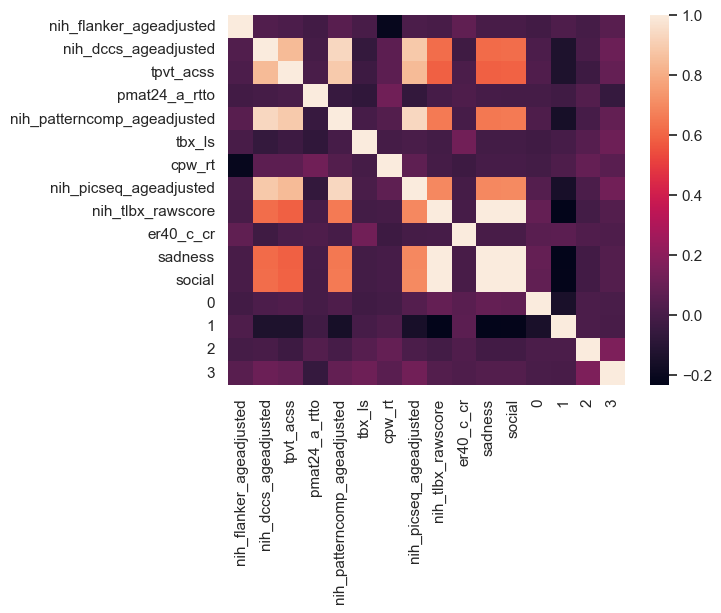

In [ ]:
import seaborn as sns

sns.heatmap(
    pd.concat([dcam_psy_df[dcam_psy_df.columns[4:]], pd.DataFrame(dcam_fa[:, 0:4])], axis=1).corr())

In [ ]:
scaled_data = StandardScaler().fit_transform(dcam_psy_df[dcam_psy_df.columns[4:]].values)
dcam_fa  = FactorAnalysis(rotation='varimax').fit_transform(scaled_data)
dcam_score = pd.DataFrame(dcam_fa)
dcam_score = dcam_score.loc[:, ~(dcam_score == 0).all()]
dcam_data = pd.concat([dcam_psy_df[['id', 'phenotype', 'interview_age', 'sex']], 
                        pd.DataFrame(dcam_fa[:, 0:4])], axis=1)

In [ ]:
n_factors=2
n_variables=banda_df_psy.columns[4:].shape

In [ ]:
cfa_model_loading = {
    "Cognition": ['nih_flanker_ageadjusted',
       'nih_dccs_ageadjusted', 'nih_patterncomp_ageadjusted', 'read_acss', "tbx_ls", 'cpw_rt'],
    "Emotion": ["er40_c_cr", "shaps_score"]
}
loadings = np.zeros((len(banda_df_psy.columns[4:]), len(cfa_model_loading)))
# Assign 1s based on model structure
for factor_idx, (factor, variables) in enumerate(cfa_model_loading.items()):
    for var in variables:
        var_idx = list(banda_df_psy.columns[4:]).index(var)
        loadings[var_idx, factor_idx] = 1

In [ ]:
cfa_model = ModelSpecification(loadings=loadings, n_factors=n_factors, n_variables=banda_df_psy.columns[4:].shape[0], factor_names=['Cognition', 'emotion'])
model = ConfirmatoryFactorAnalyzer(cfa_model, disp=False)
scaled_data = StandardScaler().fit_transform(banda_df_psy[banda_df_psy.columns[4:]].values)
model.fit(scaled_data)

ConfirmatoryFactorAnalyzer(disp=False, n_obs=203,
                           specification=<factor_analyzer.confirmatory_factor_analyzer.ModelSpecification object at 0x31cfee170>)

In [ ]:
pd.DataFrame(model.loadings_.T, columns=banda_df_psy.columns[4:])

,nih_flanker_ageadjusted,nih_dccs_ageadjusted,nih_patterncomp_ageadjusted,read_acss,er40_c_cr,shaps_score,tbx_ls,cpw_rt
0,0.820532,0.725606,0.536702,0.396609,0.000000,0.000000,0.252143,-0.238267
1,0.000000,0.000000,0.000000,0.000000,-0.022081,0.311415,0.000000,0.000000


In [ ]:
np.cov(scaled_data.T)


array([[ 1.0049505 ,  0.60528295,  0.46205004,  0.32425414, -0.03053951,
         0.07166889,  0.14789591, -0.17297113],
       [ 0.60528295,  1.0049505 ,  0.37954546,  0.26393287,  0.00101557,
         0.14240522,  0.18736726, -0.15587274],
       [ 0.46205004,  0.37954546,  1.0049505 ,  0.17080179,  0.00674104,
        -0.03687186,  0.12529031, -0.14096037],
       [ 0.32425414,  0.26393287,  0.17080179,  1.0049505 ,  0.03493631,
         0.00637835,  0.33624618, -0.17099814],
       [-0.03053951,  0.00101557,  0.00674104,  0.03493631,  1.0049505 ,
        -0.00781392,  0.11440913,  0.01520748],
       [ 0.07166889,  0.14240522, -0.03687186,  0.00637835, -0.00781392,
         1.0049505 ,  0.12961417, -0.0893345 ],
       [ 0.14789591,  0.18736726,  0.12529031,  0.33624618,  0.11440913,
         0.12961417,  1.0049505 , -0.18681213],
       [-0.17297113, -0.15587274, -0.14096037, -0.17099814,  0.01520748,
        -0.0893345 , -0.18681213,  1.0049505 ]])

In [ ]:
from sklearn.metrics import root_mean_squared_error


In [ ]:
root_mean_squared_error(np.cov(scaled_data.T), model.cov_)

0.002007151034590326

In [ ]:
import scipy.stats as stats

X, p = stats.chisquare(model.loadings_)
X

array([3.17130669, 2.40559368])

In [ ]:
banda_data = pd.concat([banda_df_psy[['id', 'phenotype', 'interview_age', 'sex']], 
                        pd.DataFrame(model.fit_transform(banda_df_psy[banda_df_psy.columns[4:]].values)).rename(columns={0: "Cognition", 1:"Emotion"})], axis=1)

<Axes: >

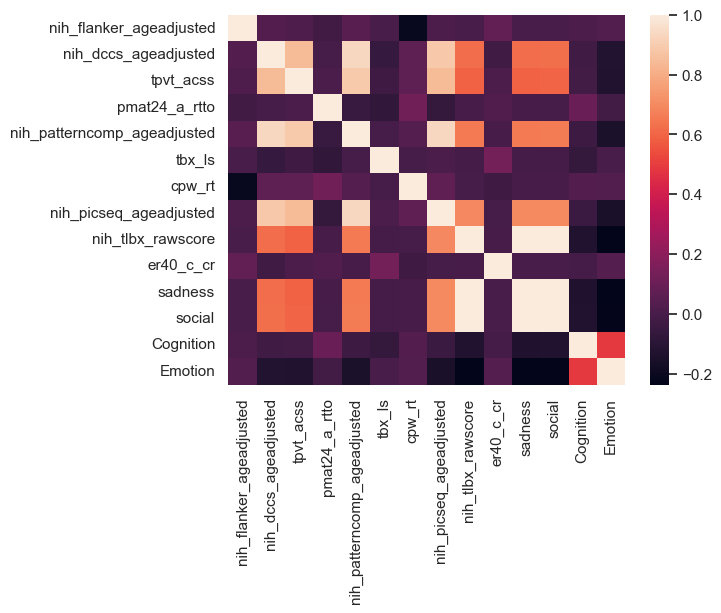

In [ ]:
import seaborn as sns

sns.heatmap(
    pd.concat([dcam_psy_df[dcam_psy_df.columns[4:]], dcam_data[["Cognition", "Emotion"]]], axis=1).corr())

In [ ]:
dcam_df['er4001']

,collection_id,er4001_id,dataset_id,subjectkey,src_subject_id,interview_date,interview_age,sex,er40_c_cr,er40_c_rtcr,...,er40_c_fpf,er40_c_fph,er40_c_fpn,er40_c_fps,er40_c_fpart,er40_c_fpfrt,er40_c_fpnrt,er40_c_fpsrt,collection_title,Study
0,collection_id,er4001_id,dataset_id,The NDAR Global Unique Identifier (GUID) for r...,Subject ID how it's defined in lab/project,Date on which the interview/genetic test/sampl...,Age in months at the time of the interview/tes...,Sex of subject at birth,ER40 Correct Responses,ER40 Correct Responses Median Response Time (ms),...,False Positive Fear Responses,False Positive Happy Responses,False Positive Neutral Responses,False Positive Sad Responses,Median Response Time for ER40_C False Positive...,Median Response Time for ER40_C False Positive...,Median Response Time for ER40_C False Positive...,Median Response Time for ER40_C False Positive...,collection_title,HCP_Study_Name
1,3161,615660,38572,NDARAB462FH0,NDARAB462FH0,01/01/2019,288,F,38,1359.5,...,2,0,0,0,NaN,2927,NaN,NaN,Dimensional connectomics of anxious misery,DCAM
2,3161,615661,38572,NDARAB921RG1,NDARAB921RG1,01/01/2018,384,F,32,1867.5,...,2,1,2,3,NaN,2719,2647,2767,Dimensional connectomics of anxious misery,DCAM
3,3161,615662,38572,NDARAC286ZE7,NDARAC286ZE7,01/01/2017,312,F,35,3304,...,1,1,1,2,NaN,7231,12615,8723.5,Dimensional connectomics of anxious misery,DCAM
4,3161,615663,38572,NDARAC789HEZ,NDARAC789HEZ,01/01/2017,492,M,37,1816,...,1,0,1,0,2863,1672,2024,NaN,Dimensional connectomics of anxious misery,DCAM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,3161,620362,50234,NDARZM711THA,NDARZM711THA,01/07/2017,432,F,34,3000.5,...,1,0,1,3,4945,1704,5441,3256,Dimensional connectomics of anxious misery,DCAM
488,3161,620363,50234,NDARZN877YYQ,NDARZN877YYQ,01/01/2019,276,F,39,1496,...,0,0,0,0,2976,NaN,NaN,NaN,Dimensional connectomics of anxious misery,DCAM
489,3161,620364,50234,NDARZP892XY9,NDARZP892XY9,01/01/2018,216,F,37,1800,...,1,0,1,1,NaN,4024,1392,2504,Dimensional connectomics of anxious misery,DCAM
490,3161,620365,50234,NDARZW884MZC,NDARZW884MZC,01/01/2017,480,M,36,1687,...,0,0,0,3,3768,NaN,NaN,1992,Dimensional connectomics of anxious misery,DCAM


In [ ]:
cog_flanker_dcam = task_transform_and_merge(dcam_df['flanker01'], 'nih_flanker_ageadjusted', dcam_particpant_info ).drop("phenotype", axis=1)
cog_dccs_dcam = task_transform_and_merge(dcam_df['dccs01'], 'nih_dccs_ageadjusted', dcam_particpant_info ).drop("phenotype", axis=1)
cog_tpvt_dcam = task_transform_and_merge(dcam_df['tpvt01'], 'tpvt_acss', dcam_particpant_info).drop("phenotype", axis=1)
cog_pmat_dcam = task_transform_and_merge(dcam_df['pmat01'], 'pmat24_a_rtto', dcam_particpant_info).drop("phenotype", axis=1)
cog_pcps_dcam = task_transform_and_merge(dcam_df['pcps01'], 'nih_patterncomp_ageadjusted', dcam_particpant_info).drop("phenotype", axis=1)
mem_lswmt_dcam = task_transform_and_merge(dcam_df['lswmt01'], 'tbx_ls', dcam_particpant_info ).drop("phenotype", axis=1)
mem_pvmt_dcam = task_transform_and_merge(dcam_df['pwmt01'], 'cpw_rt', dcam_particpant_info ).drop("phenotype", axis=1)
mem_psm_dcam = task_transform_and_merge(dcam_df['psm01'], 'nih_picseq_ageadjusted', dcam_particpant_info ).drop("phenotype", axis=1)
emo_effic_dcam = task_transform_and_merge(dcam_df['self_effic01'], 'nih_tlbx_rawscore', dcam_particpant_info).drop("phenotype", axis=1)
emo_er_40_dcam = task_transform_and_merge(dcam_df['er4001'], 'er40_c_cr', dcam_particpant_info).drop("phenotype", axis=1)
emo_sadness_dcam = task_transform_and_merge(dcam_df['tlbx_sadness01'], 'nih_tlbx_rawscore', dcam_particpant_info).drop("phenotype", axis=1).rename(columns={
    "nih_tlbx_rawscore": "sadness"
})
soc_socwit_dcam = task_transform_and_merge(dcam_df['tlbx_socwit01'], 'nih_tlbx_rawscore', dcam_particpant_info).drop("phenotype", axis=1).rename(columns={
    "nih_tlbx_rawscore": "social"
})

In [ ]:
dcam_psy_df = [cog_flanker_dcam,
cog_dccs_dcam,
cog_tpvt_dcam,
cog_pmat_dcam,
cog_pcps_dcam,
mem_lswmt_dcam ,
mem_pvmt_dcam,
mem_psm_dcam,
emo_effic_dcam ,
emo_er_40_dcam,
emo_sadness_dcam,
soc_socwit_dcam]
dcam_psy_df = reduce(lambda left, right: pd.merge(left, right, on='id', how='outer'), dcam_psy_df)

In [ ]:
dcam_psy_df = pd.merge(dcam_particpant_info, dcam_psy_df, on='id', how='left')
grouping = dcam_psy_df.groupby("phenotype")
try:
     del(transformed_final)
except Exception:
     pass
transformed_final = {}
for group_id in grouping.groups.keys():
    df = grouping.get_group(group_id)
    for col in df.columns[4:]:
         mean_value = df[col].mean(skipna=True)
         df.loc[df[col].isna(), col] = mean_value
         transformed_final[group_id] = df
dcam_psy_df = pd.concat([transformed_final[group] for group in transformed_final.keys()])

In [ ]:
cfa_model_loading = {
    "Cognition": [
       'nih_dccs_ageadjusted', 'nih_patterncomp_ageadjusted', 'tpvt_acss', "nih_picseq_ageadjusted", 
      ],
    "Emotion": ["er40_c_cr", "sadness", "social", "nih_tlbx_rawscore"]
}
loadings = np.zeros((len(dcam_psy_df.columns[4:]), len(cfa_model_loading)))
# Assign 1s based on model structure
for factor_idx, (factor, variables) in enumerate(cfa_model_loading.items()):
    for var in variables:
        var_idx = list(dcam_psy_df.columns[4:]).index(var)
        loadings[var_idx, factor_idx] = 1

In [ ]:
cfa_model = ModelSpecification(loadings=loadings, n_factors=n_factors, n_variables=dcam_psy_df.columns[4:].shape[0], factor_names=['Cognition', 'emotion'])
model = ConfirmatoryFactorAnalyzer(cfa_model, disp=False)
scaled_data = StandardScaler().fit_transform(dcam_psy_df[dcam_psy_df.columns[4:]].values)
model.fit(scaled_data)

NameError: name 'ModelSpecification' is not defined

In [ ]:

X, p = stats.chisquare(model.loadings_)
p

array([0.72403328, 0.71894099])

In [ ]:
dcam_data = pd.concat([dcam_psy_df[['id', 'phenotype', 'interview_age', 'sex']], 
                        pd.DataFrame(model.fit_transform(dcam_psy_df[dcam_psy_df.columns[4:]].values)).rename(columns={0: "Cognition", 1:"Emotion"})], axis=1)

/Users/mszdjh3/envs/global/lib/python3.10/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:753: UserWarning: The optimization routine failed to converge: ABNORMAL_TERMINATION_IN_LNSRCH
  warnings.warn(


In [ ]:
dcam_data.isna().sum()

id                0
phenotype         0
interview_age     0
sex               0
0                43
1                43
2                43
3                43
dtype: int64

In [ ]:
cluster_df = pd.concat([banda_data, dcam_data])
cluster_df['sex'] = cluster_df['sex'].apply(lambda x: 0 if x == 'F' else 1)
cluster_df['interview_age'] = cluster_df['interview_age'].astype('float')

In [ ]:
cluster_df.isna().sum()

id               0
phenotype        0
interview_age    0
sex              0
0                0
1                0
2                0
3                0
dtype: int64

In [ ]:
from sklearn.decomposition import PCA
decomp = PCA()
cluster_df.columns = cluster_df.columns.astype(str)
pca_df = cluster_df[cluster_df.columns[3:]]
scaled_data = scaling(pca_df)
scaled_data = pd.concat([cluster_df['interview_age'].reset_index(drop=True), scaled_data.reset_index(drop=True)], axis=1)
alt = decomp.fit_transform(scaled_data)
null_distro = permutation_null_distro(pd.concat([cluster_df['interview_age'].reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1), n_perms=5000)
crti_val = get_crit_val(len(decomp.explained_variance_ratio_), null_distro)
alt_val = get_explained_ratio(decomp, len(decomp.explained_variance_ratio_))
comp = get_significant_components(crti_val, alt_val)
print(f"Component(s) {comp} are sigifiniciant components")

Component(s) [0] are sigifiniciant components


In [ ]:
scaled_data = scaling(pca_df)
alt_pca = PCA(n_components=1).fit_transform(scaled_data.values)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scaled_data = scaling(cluster_df[cluster_df.columns[2:]])
alt_pca = PCA(n_components=1).fit_transform(scaled_data.values)
cluster_range = range(2, 11)
for cluster_n in cluster_range:
    clusterer = KMeans(n_clusters=cluster_n, random_state=10)
    cluster_labels = clusterer.fit_predict(alt_pca)
    silhouette_avg = silhouette_score(alt_pca, cluster_labels)
    print("For n_clusters =", cluster_n, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.5036738681258219
For n_clusters = 3 The average silhouette_score is : 0.5446989383470114
For n_clusters = 4 The average silhouette_score is : 0.5730053169348099
For n_clusters = 5 The average silhouette_score is : 0.5255768328892152
For n_clusters = 6 The average silhouette_score is : 0.5394194547686533
For n_clusters = 7 The average silhouette_score is : 0.527549351460595
For n_clusters = 8 The average silhouette_score is : 0.5168732416549009
For n_clusters = 9 The average silhouette_score is : 0.5199556383831395
For n_clusters = 10 The average silhouette_score is : 0.528310321451957


In [ ]:
kmeans = KMeans(init="k-means++", n_clusters=4, n_init=4)
kmeans.fit(alt_pca)
cluster_df['group'] = kmeans.labels_

In [ ]:
group = cluster_df.groupby("group")
numbers = group.count()['sex'].rename("Count")
phenotype = group['phenotype'].unique().rename("phenotype")
pd.concat([numbers, phenotype, group[["0", "1", "2", "3"]].mean()], axis=1)

,Count,phenotype,0,1,2,3
group,,,,,,
0,77,"[Control, MDD]",0.171030,-0.241725,-0.112940,-0.071850
1,128,"[Anxiety, Control, Depression, MDD]",0.147435,0.354338,0.067660,0.076809
2,6,"[Depression, MDD]",2.228885,4.811410,-0.407330,-0.057851
3,238,"[Anxiety, Control, Depression, MDD]",-0.190816,-0.233659,0.010419,-0.016605


In [ ]:
import seaborn as sns
sns.set_theme("notebook")
from sklearn.cluster import KMeans

reduced_data = PCA(n_components=1).fit_transform(alt_pca)
n_digits = 4
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(alt_pca)
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Pastel1,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="b",
    zorder=10,
)
plt.title(
    "K-means clustering on data\n"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
import seaborn as sns

sns.heatmap(
    banda[banda.columns[4:]].corr())